### SQL-Abfragen in Relationale Algebra konvertieren

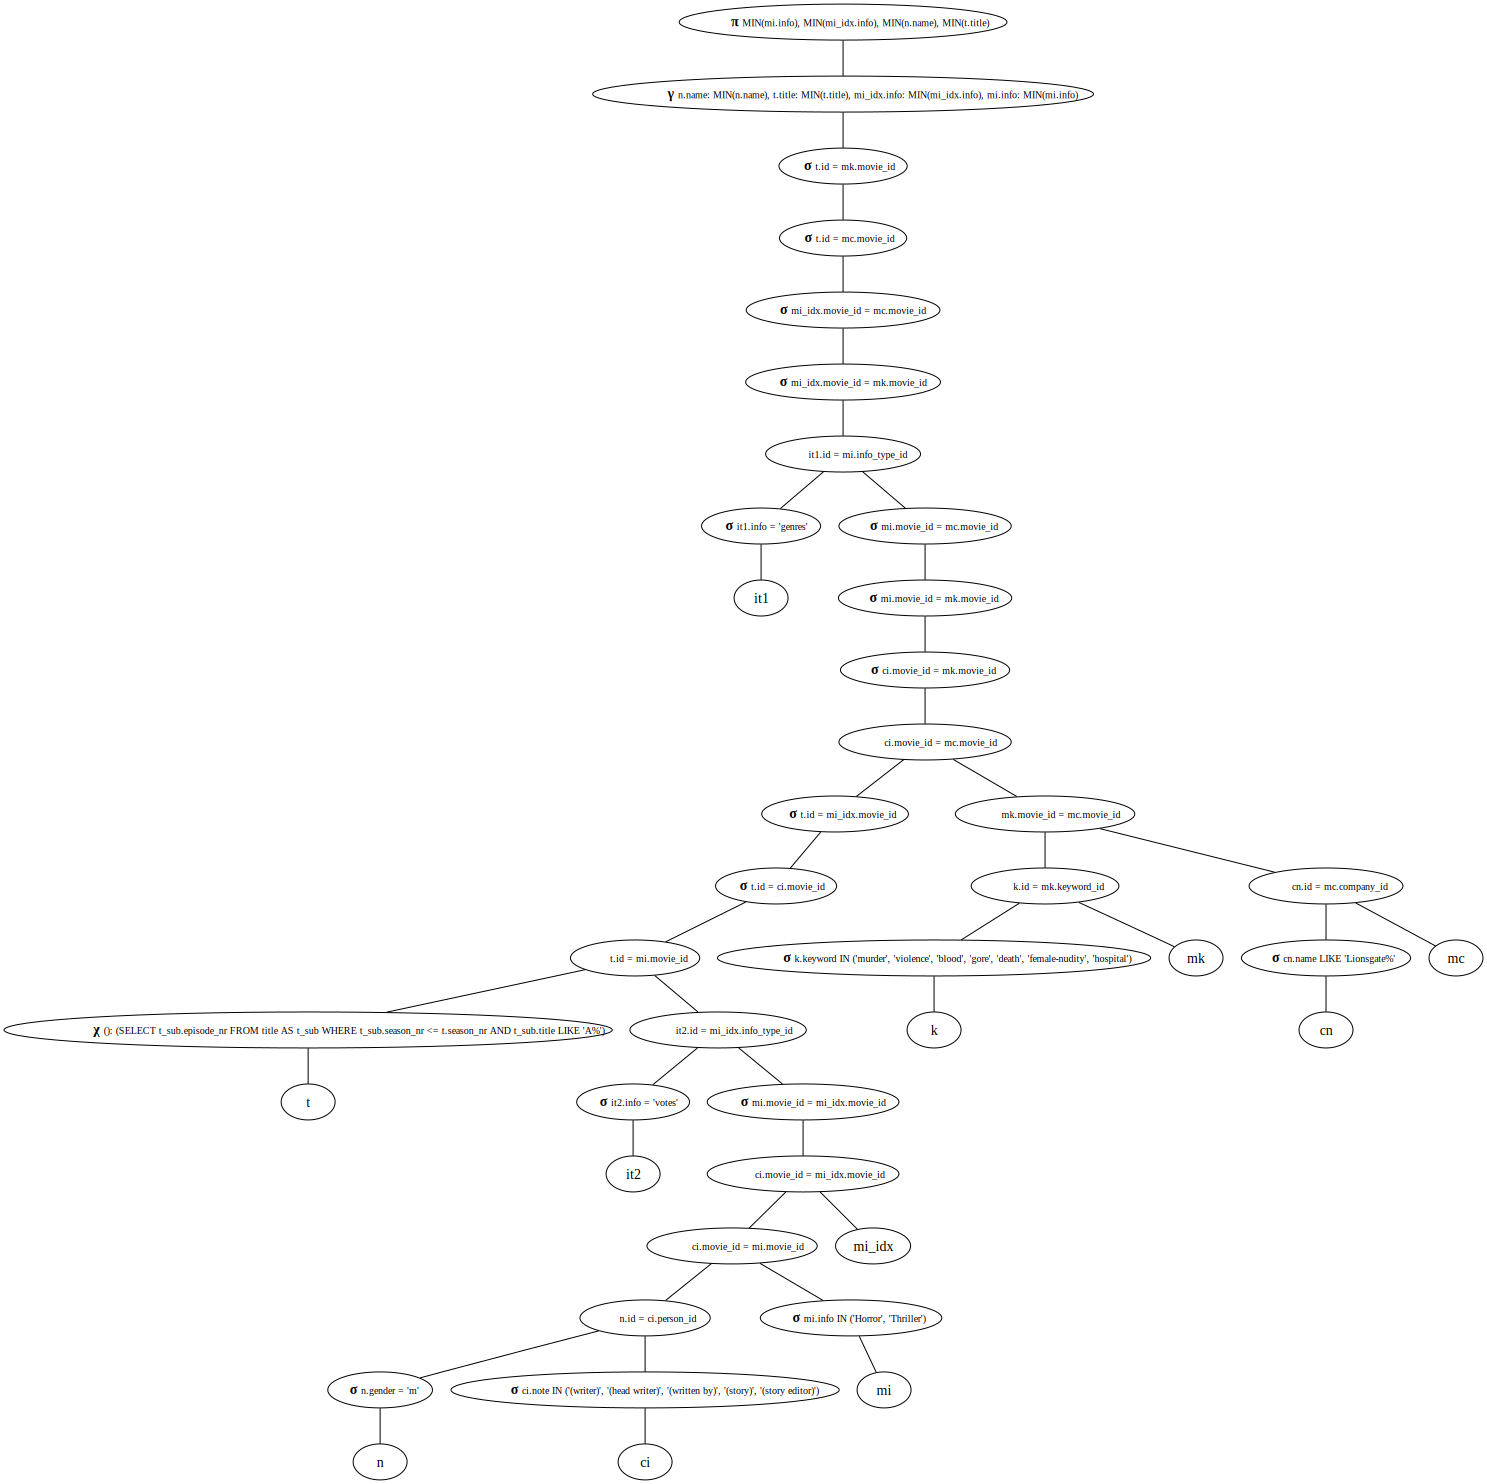

In [11]:
from postbound.vis import optimizer as opt_vis

from src.parser.parser import Parser

parser = Parser()

sql_query_1 = "select s.name,e.course from exams e, students s where s.id = e.sid and e.grade = (select min(e2.grade) from exams e2 where s.id = e2.sid);"

sql_query_2 = "select s.name, e.course from   students s, exams e where  s.id=e.sid and (s.major = 'CS' or s.major = 'Games Eng') and e.grade>=(select avg(e2.grade)+1 from exams e2 where s.id=e2.sid or (e2.curriculum=s.major and s.year>e2.date))"

sql_query_3 = "SELECT MIN(mi.info) AS movie_budget, MIN(mi_idx.info) AS movie_votes, MIN(n.name) AS writer, MIN(t.title) AS violent_liongate_movie FROM cast_info AS ci, company_name AS cn, info_type AS it1, info_type AS it2, keyword AS k, movie_companies AS mc, movie_info AS mi, movie_info_idx AS mi_idx, movie_keyword AS mk, name AS n, title AS t WHERE ci.note IN ('(writer)', '(head writer)', '(written by)', '(story)', '(story editor)') AND cn.name LIKE 'Lionsgate%' AND it1.info = 'genres' AND it2.info = 'votes' AND k.keyword IN ('murder', 'violence', 'blood', 'gore', 'death', 'female-nudity', 'hospital') AND mi.info IN ('Horror', 'Thriller') AND n.gender = 'm' AND t.id = mi.movie_id AND t.id = mi_idx.movie_id AND t.id = ci.movie_id AND t.id = mk.movie_id AND t.id = mc.movie_id AND ci.movie_id = mi.movie_id AND ci.movie_id = mi_idx.movie_id AND ci.movie_id = mk.movie_id AND ci.movie_id = mc.movie_id AND mi.movie_id = mi_idx.movie_id AND mi.movie_id = mk.movie_id AND mi.movie_id = mc.movie_id AND mi_idx.movie_id = mk.movie_id AND mi_idx.movie_id = mc.movie_id AND mk.movie_id = mc.movie_id AND n.id = ci.person_id AND it1.id = mi.info_type_id AND it2.id = mi_idx.info_type_id AND k.id = mk.keyword_id AND cn.id = mc.company_id AND t.episode_nr not in (SELECT t_sub.episode_nr FROM title AS t_sub WHERE t_sub.season_nr <= t.season_nr AND t_sub.title LIKE 'A%')"

relalg_query_1 = parser.parse_relalg(sql_query_1)
relalg_query_2 = parser.parse_relalg(sql_query_2)
relalg_query_3 = parser.parse_relalg(sql_query_3)
opt_vis.plot_relalg(relalg_query_3)

### Optimierung

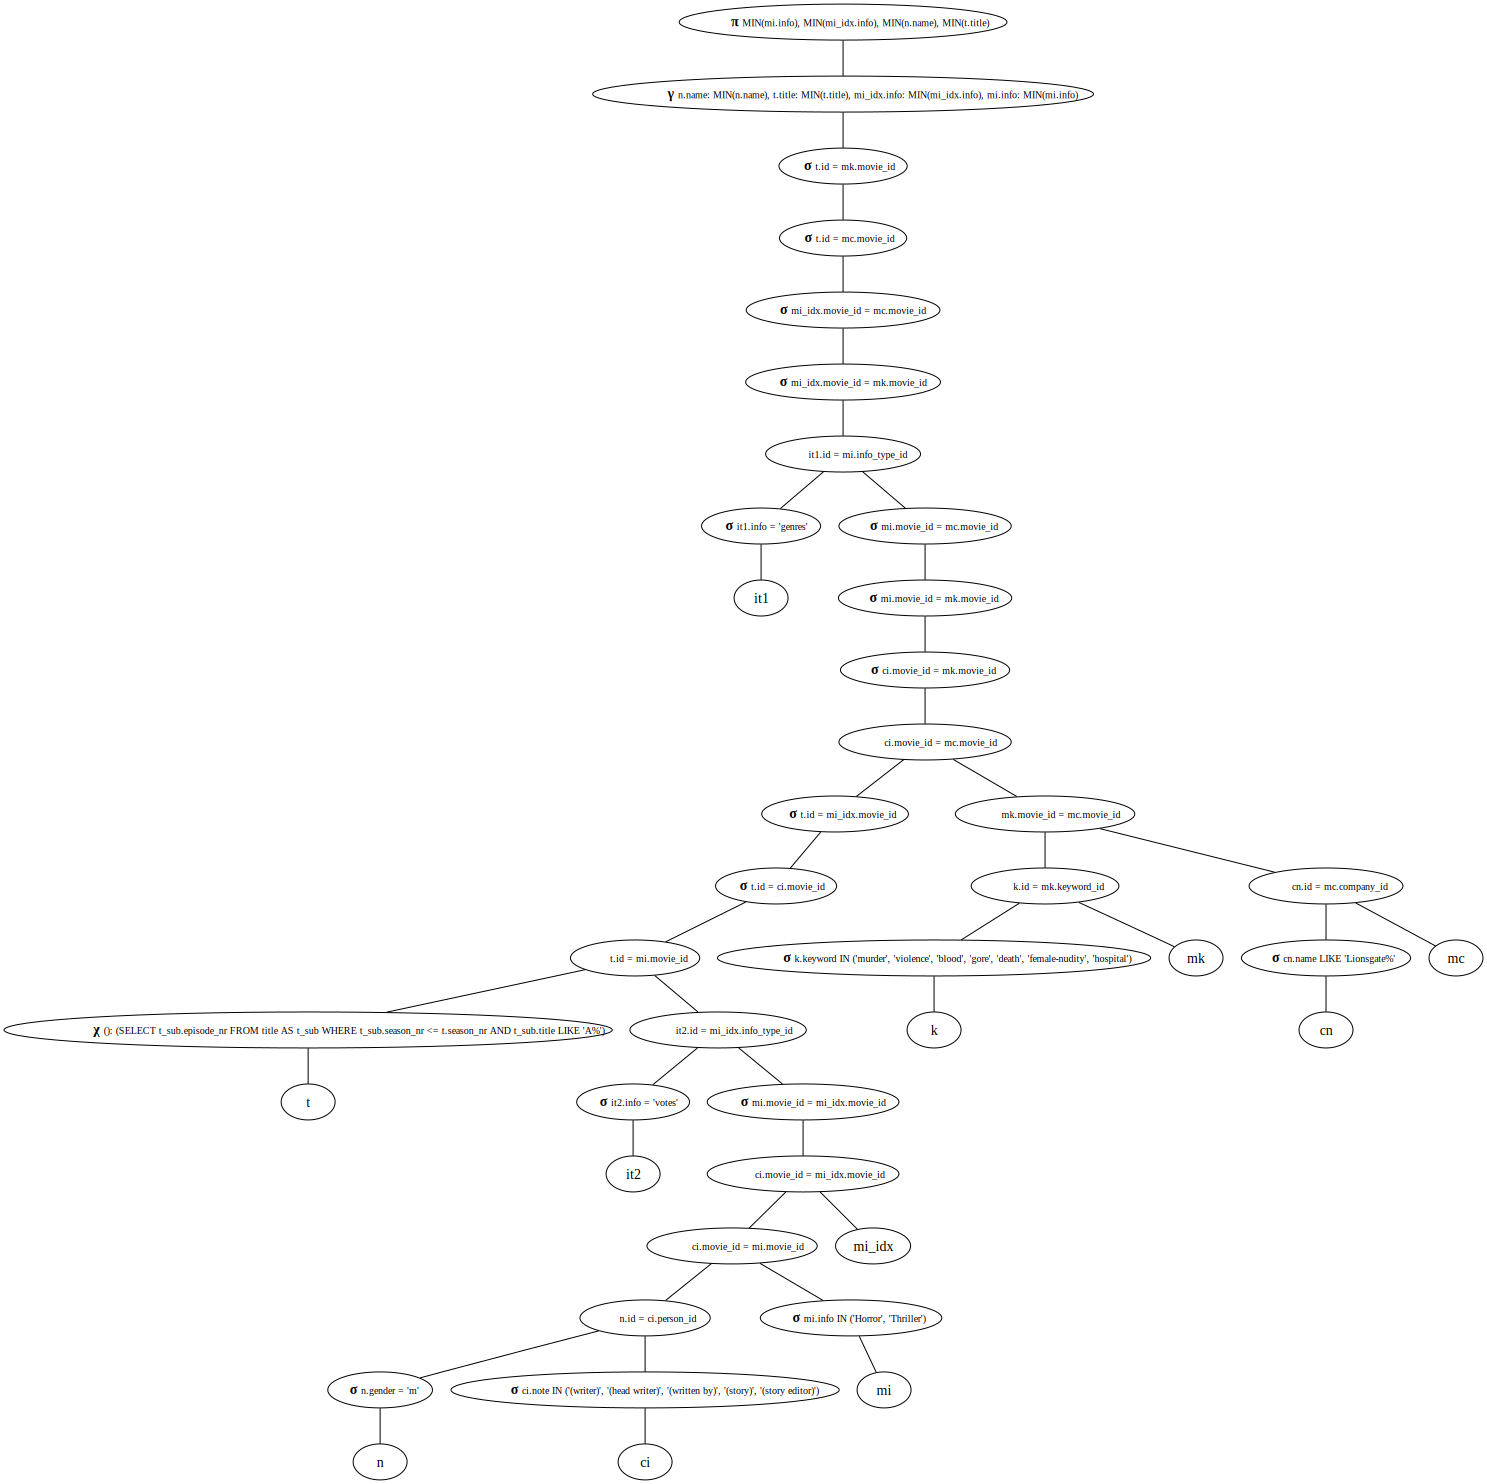

In [12]:
from src.utils.utils import Utils
from src.optimizer.push_down_manager import PushDownManager
from src.optimizer.optimizer import Optimizer

utils = Utils()
pushDownManager = PushDownManager(utils)
optimizer = Optimizer(utils)
result = optimizer.optimize_unnesting(relalg_query_3)

opt_vis.plot_relalg(result)


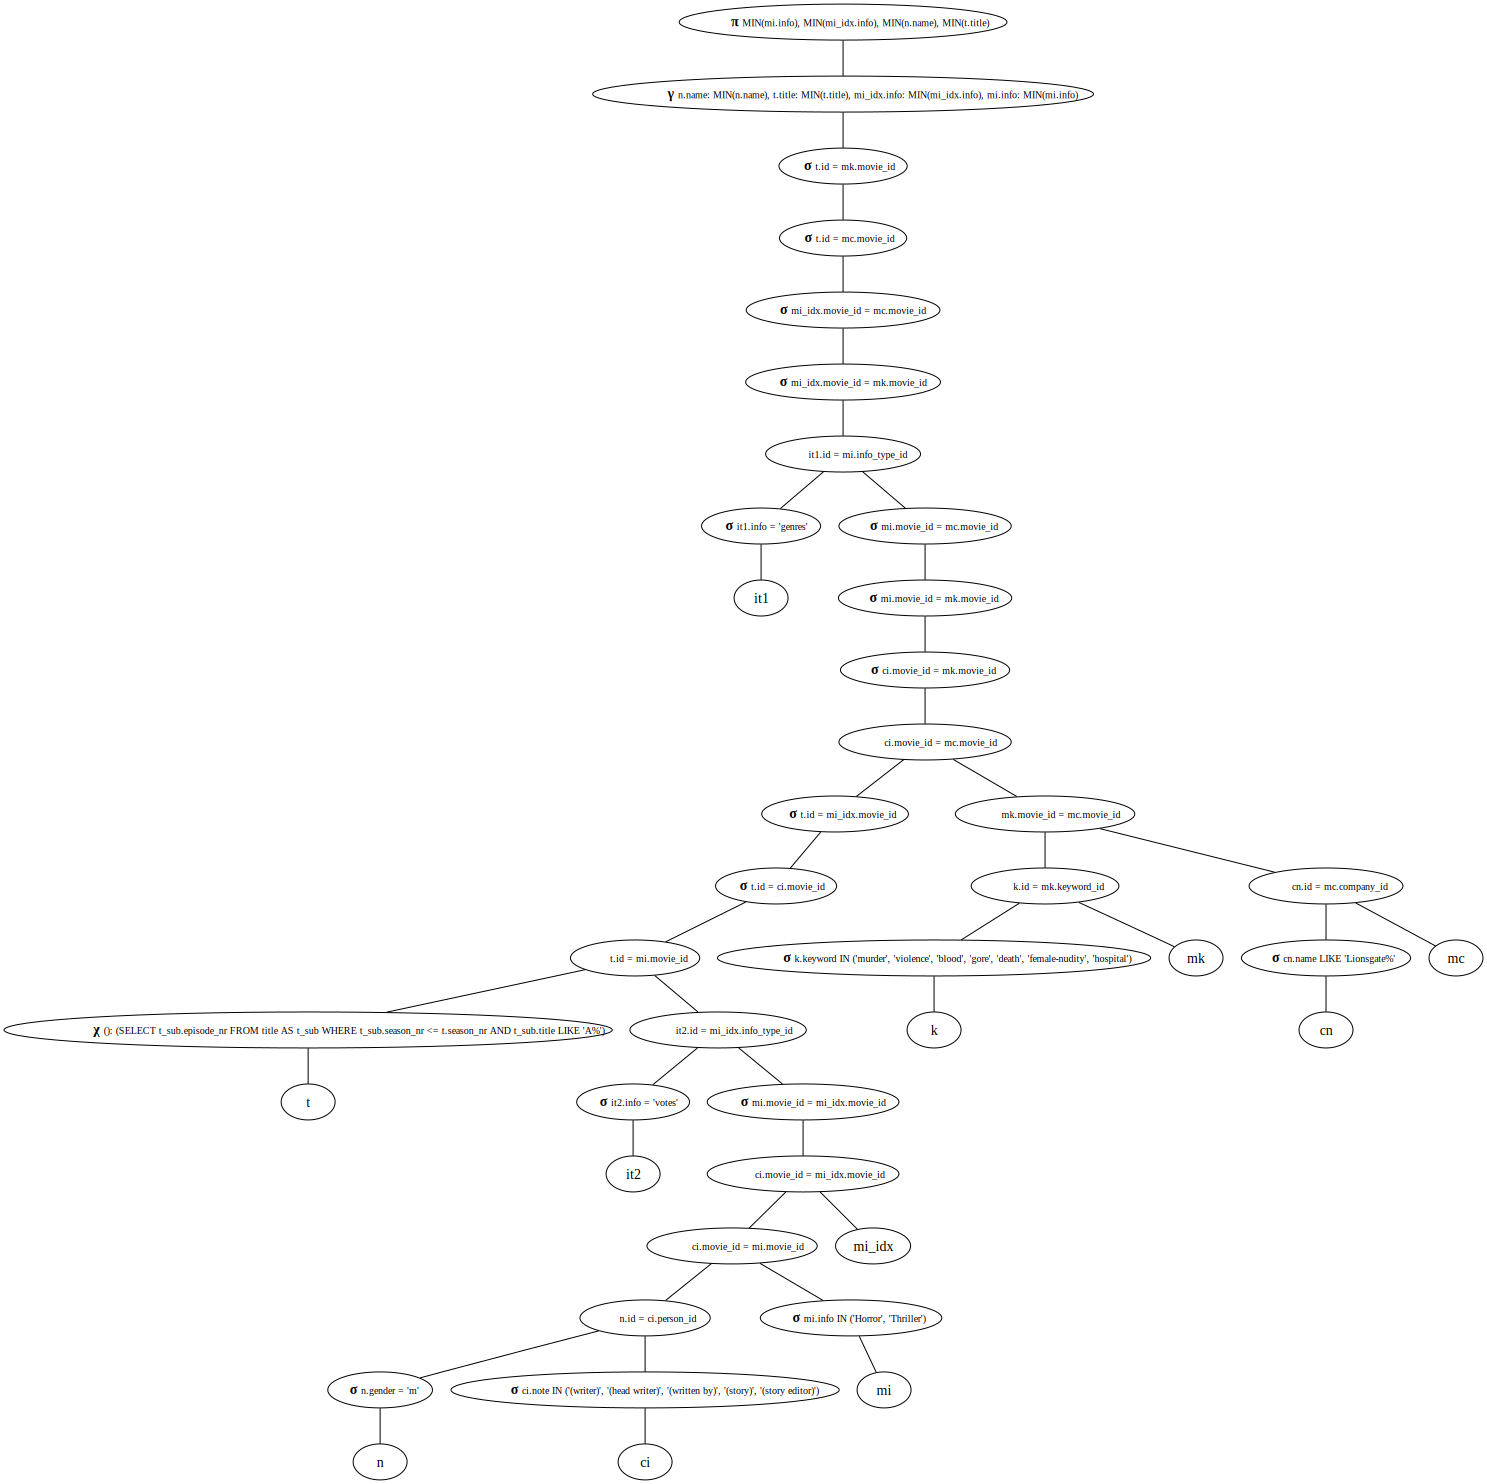

In [13]:
push_down, subquery_root = pushDownManager.push_down(result)
opt_vis.plot_relalg(push_down)

In [14]:
from postbound.qal import formatter
from src.query_generator.query_generator import QueryGenerator

query_generator = QueryGenerator(utils)
final_query = query_generator.generate_sql_from_relalg(push_down, subquery_root)
print(formatter.format_quick(final_query))

AttributeError: 'NoneType' object has no attribute 'left_input'